# Using Bayesian Decision Making to Operate a Space Port

(c) 2019 Thomas Wiecki & Ravin Kumar

## Bayesian Decision Making

There are many good reasons for adopting a Bayesian perspective when solving structured data science problems. Sean J Taylor recently had a great [Twitter thread](https://threadreaderapp.com/thread/1073632404286275584.html) on some of the benefits. While we wholeheartedly agree with that list, there was one crucial thing missing, as [Cam] [highlighted](https://twitter.com/Cmrn_DP/status/1073666044902940673): "being able to apply a loss function/decision function to a posterior and get a even _more_ interpretable posterior distribution." He was, in essence, referring to Bayesian Decision Making. In brief, this is when you estimate your posteriors and then plug those into a loss function that, together with an optimizer, allows you to make "optimal" (conditioned on your model) decisions.

This is a huge deal, as it takes Bayesian statistics from something that informs a decision to something that *makes* a decision. And it turns out that informing a decision is in practice not always that useful.

We recently learned that directly when using Bayesian statistics at [Quantopian](https://www.quantopian.com) to select algorithms for our fund. [Adrian Seyboldt] built a really cool Bayesian model that would tell us the probability that an algorithm would make money, based on the daily returns of that algorithm. That sounds like it should help us make better decisions when selecting algorithms, right? 

Unfortunately not, because how do you actually make use of that probability. You could define a cut-off, like 95% probability that the algorithm has positive expected value. Unfortunately, you'd have to wait a **really** long time for any algorithm to cross that threshold so you would never invest in anything. So that's not really useful. 

Alternatively you still make human decisions in selecting algorithms but now can make better decisions because you have that number. Unfortunately that also doesn't really work because saying "this one has a 70% probability, and that one a 65% probability" is really hard to actually incorporate in a meaningful way.

The real game changer was to just let Bayesian Decision Making sort it out and plug all our probability distributions for every algorithm into an optimizer and let that figure out which algorithms to select and how much capital to assign to each one. All of a sudden, something that seemed cool but didn't really matter in practice was converted to something that took care of our algorithm selection *and* our capital allocation problem in one go.

In this blog post we want to demonstrate this powerful tool with a practical problem: **Optimizing supply chains**.

In [87]:
%matplotlib inline

import pymc3 as pm
import theano.tensor as tt
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

## Supply chain optimization to run a space port

It is the year 12103 (under our [new Human Era](https://www.youtube.com/watch?v=czgOWmtGVGs) calendar), Man has become a space-faring civilization. Bayesians and Frequentists still argue about which statistics are better. You are the operator of a space port called PyMC-X that sends humans to the moon, Mars, Europa, and the ISS 5.0 in Saturn's orbit. 

While the rockets are reusable, we need a new rocket engine for every launch. We buy our engines from three suppliers. These suppliers have different prices, different quality items, and different maximum amounts they can ship you within a certain timeframe:

In [309]:
SUPPLIER_YIELD = np.array([.9, .5, .8])
SUPPLIER_YIELD_SD = np.array([.1, .2, .2])
PRICES = [190.0, 100.0, 120.0]
MAX_ORDER_SIZE = [100, 80, 100]

The yield represents the percentage of engines that pass our stress tests (a faulty engine lead to the [abort of the launch of STS-93](https://www.youtube.com/watch?v=T7vGqQUhciE)). Due to different manufacturing techniques, the yield varies quite a bit, which is also reflected in the price. While we know the prices and maximum order sizes, we can't directly observe the true yield but will have to estimate it from previous batches we ordered. We have ordered different times from different suppliers. For example, as supplier 2 only opened up recently, we only ordered twice from there:

In [323]:
N_OBS = [30, 20, 2]

In [330]:
np.random.seed(100)
data = []
for supplier_yield, supplier_yield_sd, n_obs in zip(SUPPLIER_YIELD, SUPPLIER_YIELD_SD, N_OBS):
    data.append(pm.Beta.dist(mu=supplier_yield, sd=supplier_yield_sd, shape=n_obs).random())
    
data

[array([0.978235  , 0.98946102, 0.99035051, 0.83762708, 0.66130327,
        0.98785994, 0.85327018, 0.8500779 , 0.99913878, 0.89881072,
        0.8175994 , 0.95181804, 0.91545214, 0.87137954, 0.96166603,
        0.99033823, 0.96319861, 0.94124979, 0.96555922, 0.96606356,
        0.92723444, 0.97736913, 0.86764773, 0.81749131, 0.98597604,
        0.97980665, 0.77295709, 0.9584931 , 0.88875261, 0.99585613]),
 array([0.51788973, 0.67831661, 0.64888304, 0.61595363, 0.08634205,
        0.72543455, 0.51883833, 0.5454235 , 0.30357696, 0.21743938,
        0.54628383, 0.68559965, 0.28827533, 0.79246239, 0.65810975,
        0.69059483, 0.59297579, 0.85482231, 0.38115298, 0.8296909 ]),
 array([0.89241857, 0.9000698 ])]

/Users/twiecki/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


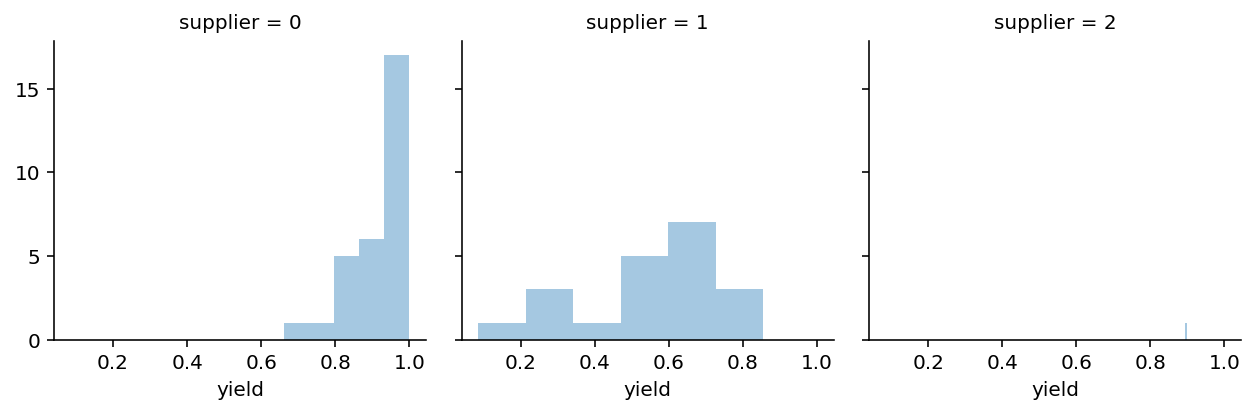

In [332]:
data_df = pd.DataFrame(data).T
data_tidy = data_df.unstack().to_frame('yield')
data_tidy.index = data_tidy.index.set_names(['supplier', 'obs'])
g = sns.FacetGrid(data=data_tidy.reset_index().dropna(), col='supplier')
g.map(sns.distplot, 'yield', kde=False);

## The dynamics of operating a space port

In order to assess how many engines we need we first need to know how many rocket launchs we can sell. If we buy too few we are leaving money on the table, if we buy too many we will have to put them in storage which costs money. Let's assume we can sell a rocket for 500 bitcoins and it costs us 100 bitcoins in holding cost.

In [333]:
SALES_PRICE = 500 
HOLDING_COST = 100

Next, let's define our loss function which takes as inputs how many engines we have in stock, how many launches customers want, at what price we bought the engine, at what price we can sell the launch, and what the holding costs are per engine:

In [334]:
@np.vectorize
def loss(in_stock, demand, buy_price, sales_price=SALES_PRICE, holding_cost=HOLDING_COST):
    # How much do we earn per piece
    margin = sales_price - buy_price
    # Do we have more in stock than demanded?
    if in_stock > demand:
        total_profit = demand * margin
        # put everything left over in holding
        total_storing_cost = (in_stock - demand) * holding_cost
        reward = total_profit - total_holding_cost
    else:
        # Can only sell what we have in stock, no storage required
        reward = in_stock * margin

    return -reward

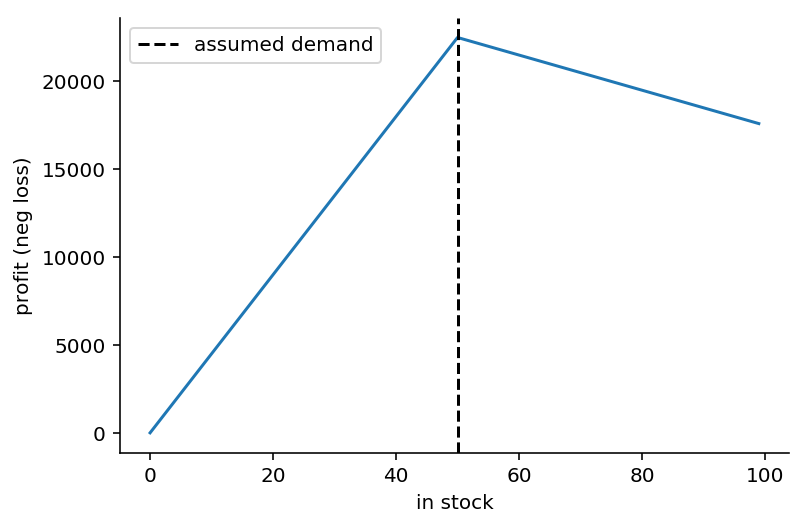

In [335]:
in_stock = np.arange(0, 100)
plt.plot(in_stock, -loss(in_stock, 50, 50))
plt.xlabel('in stock'); plt.ylabel('profit (neg loss)')
plt.axvline(50, c='k', ls='--', label='assumed demand')
sns.despine()
plt.legend();

As you can see, if customer demand is 50 launches, we maximize our profit if we have 50 engines in stock. Having fewer eats into our profits more than having more because in this setup our margins are larger than the holding cost.

Next, we need our estimate of demand. As we have a long history of launches we have a pretty good idea of what the distribution looks like:

/Users/twiecki/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


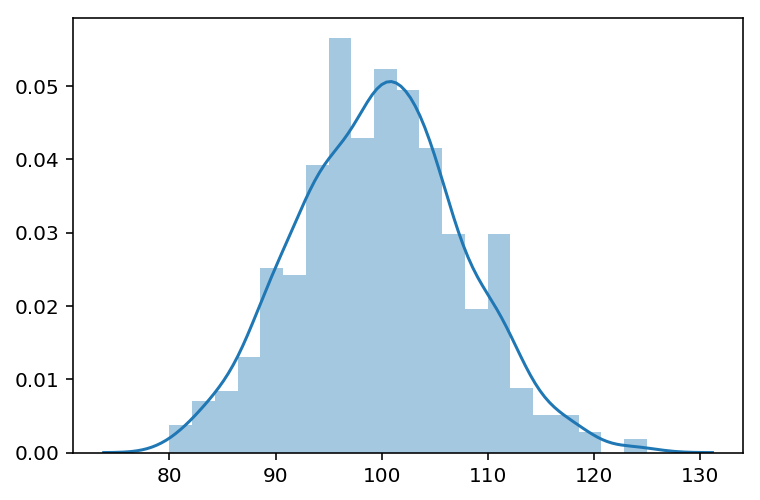

In [340]:
demand_samples = stats.poisson(60, 40).rvs(1000)
sns.distplot(demand_samples);

We can evaluate our objective function over the demand we expect (setting engines in stock to `100`):

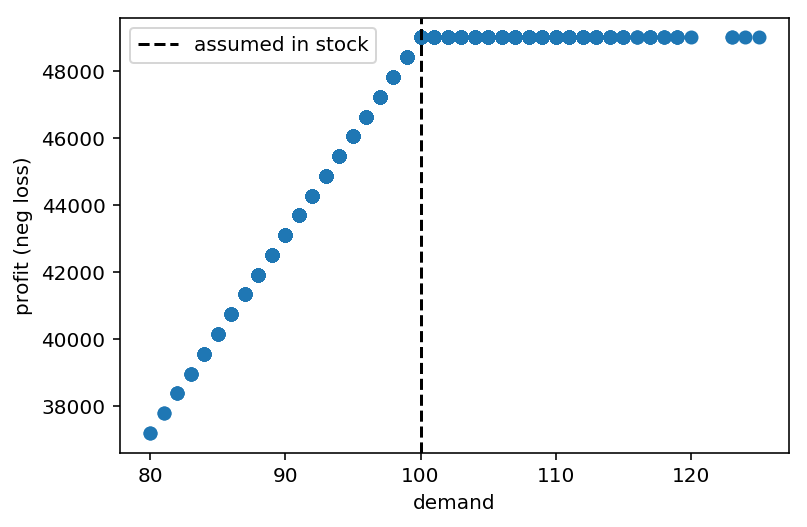

In [383]:
plt.scatter(demand_samples, -loss(100, demand_samples, 10))
plt.xlabel('demand'); plt.ylabel('profit (neg loss)'); plt.axvline(100, c='k', ls='--', label='assumed in stock');
plt.legend();

In response to demand the loss-function behaves differently: with less demand we earn less (because we sell fewer launches but also have to pay holding costs), but as demand exceeds the number of engines we have in stock our profit stays flat because we can't sell more than what we have.

## Estimating yield with a Bayesian model

Let's use `PyMC3000` (which has remarkably similar syntax to `PyMC3`) to build a model to estimate the yield of every engine supplier:

In [384]:
with pm.Model() as model:
    # Priors on alpha and beta parameters for each supplier
    α = pm.HalfNormal('α', sd=10., shape=3)
    β = pm.HalfNormal('β', sd=10., shape=3)
    
    # Different likelihood for every supplier because we have different
    # number of data points
    for i, d in enumerate(data):
        pm.Beta(f'supplier_yield_obs_{i}', 
            alpha=α[i], beta=β[i],
            observed=d)
    
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:03<00:00, 530.02draws/s]
/Users/twiecki/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


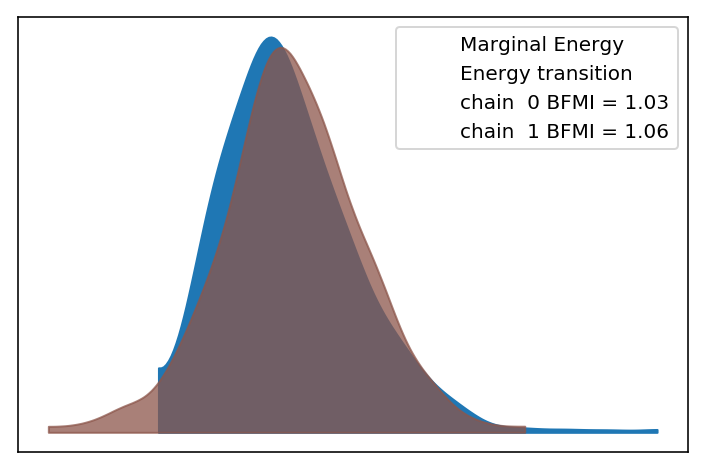

In [385]:
# make sure convergence looks good
az.plot_energy(trace);

## Generate possible future scenarios

In order to perform Bayesian Decision Making we need an estimate of what the future might look like. As we are in a generative framework this is trivial: we just need to sample from the [posterior predictive distribution](https://en.wikipedia.org/wiki/Posterior_predictive_distribution).

In [386]:
with model:
    post_pred = pm.sample_posterior_predictive(trace)

100%|██████████| 1000/1000 [00:02<00:00, 449.52it/s]


/Users/twiecki/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


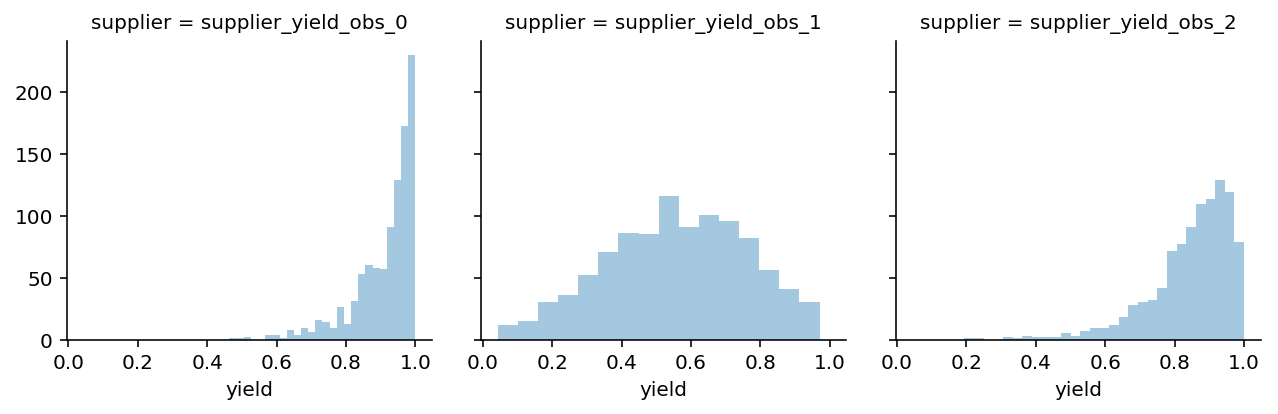

In [387]:
supplier_yield_post_pred = pd.DataFrame({k: v[:, 1] for k, v in post_pred.items()})
#supplier_yield_post_pred = pd.DataFrame({k: np.mean(v, 1) for k, v in post_pred.items()})
data_tidy = supplier_yield_post_pred.unstack().to_frame('yield')
data_tidy.index = data_tidy.index.set_names(['supplier', 'obs'])
g = sns.FacetGrid(data=data_tidy.reset_index().dropna(), col='supplier')
g.map(sns.distplot, 'yield', kde=False);

This plot shows, given the data and our model, what we can expect. Note that these predictions take the uncertainty into account. For supplier 2 we have a lot of uncertainty because we only observed very few data points.

Given these estimates we can write a function that converts the orders we place to each supplier, the yield we assume for each one, and what their prices are.

In [390]:
def calc_yield_and_price(orders, 
                         supplier_yield=np.array([.9, .5, .8]),
                         prices=PRICES
                        ):
    orders = np.asarray(orders)
    
    full_yield = np.sum(supplier_yield * orders)
    price_per_item = np.sum(orders * prices) / np.sum(orders)
    
    return full_yield, price_per_item

calc_yield_and_price([100, 60, 60])

(168.0, 146.36363636363637)

So given these conditions, we would receive 168 functioning engines at an effective price of ~146 BTC.

## Bayesian Decision Making

Now we have to actually do the optimization. First, we need to specify our objective function which will compute the total yield and effective price given a posterior predictive sample. Once we have that and our demand (also a sample from that distribution), we can compute our loss. As we have a distribution over possible scenarios, we compute the loss for each one and return the distribution.

In [389]:
def objective(orders, supplier_yield=supplier_yield_post_pred,
              demand_samples=demand_samples):
    orders = np.asarray(orders)
    losses = []
    
    if np.any(orders < 0):
        return np.inf
    
    for i, sy in supplier_yield.iterrows():
        full_yield, price_per_item = calc_yield_and_price(
            orders,
            supplier_yield=sy
        )
        
        loss_i = loss(full_yield, demand_samples[i], price_per_item)
        
        losses.append(loss_i)
        
    return np.asarray(losses)

In [344]:
from scipy import optimize

In [388]:
# parameters for the optimization, we're just including the max order sizes as bounds
bounds = [(0, max_order) for max_order in MAX_ORDER_SIZE]
starting_value = [100., 100., 100.]

In [391]:
# minimize the expected loss under all possible scenarios
opt_stoch = optimize.minimize(lambda *args: np.mean(objective(*args)), 
                              starting_value, 
                              bounds=bounds)

In [392]:
opt_stoch.x

array([ 0.        , 55.39840354, 94.13372778])

In [405]:
np.sum(opt_stoch.x)

149.532131322211

Great, we did it! Although we do want to know if this approach actually did better than something naive. For our naive approach, we just take the average yield from each supplier:

In [393]:
supplier_yield_mean = pd.DataFrame([np.mean(d) for d in data]).T
supplier_yield_mean

,0,1,2
0,0.918735,0.558903,0.896244


and the demand we expect on average (`100`). We can still use the above objective function but note that the loop will just run once. 

In [394]:
opt_non_stoch = optimize.minimize(lambda *args: objective(*args, 
                                                          supplier_yield=supplier_yield_mean, 
                                                          demand_samples=[100])[0], 
                                  starting_value, 
                                  bounds=bounds)

In [395]:
opt_non_stoch.x

array([33.89472671, 51.61717975, 44.64266078])

In [404]:
np.sum(opt_non_stoch.x)

130.15456724502258

Quite a different result from above. The full Bayesian treatment seems to dislike our high-cost but high-quality supplier and also order more to account for the lower yield. But which one is actually better in terms of profit?

To answer that qustion, we will generate new data from our true generative model and compute the profit in each new scenario given the order amounts from the two optimizations.

In [396]:
np.random.seed(123)
data_new = []
for supplier_yield, supplier_yield_sd, n_obs in zip(SUPPLIER_YIELD, SUPPLIER_YIELD_SD, N_OBS):
    data_new.append(pm.Beta.dist(mu=supplier_yield, sd=supplier_yield_sd, shape=1000).random())
data_new = pd.DataFrame(data_new).T
data_new.head()

,0,1,2
0,0.880298,0.752686,0.997934
1,0.698046,0.307304,0.971085
2,0.676807,0.534287,0.891209
3,0.943773,0.666368,0.975907
4,0.911538,0.457898,0.556483


/Users/twiecki/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


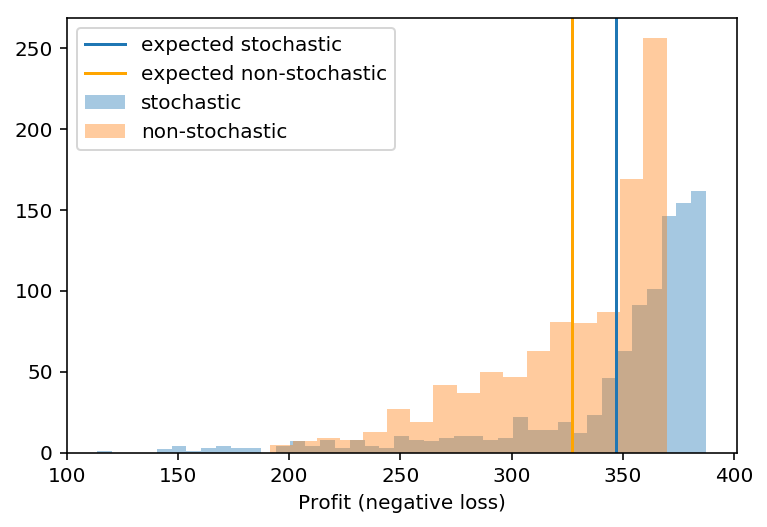

In [406]:
neg_loss_stoch = -objective(opt_stoch.x, supplier_yield=data_new) / demand_samples
neg_loss_non_stoch = -objective(opt_non_stoch.x, supplier_yield=data_new) / demand_samples
sns.distplot(neg_loss_stoch, label='stochastic', kde=False)
plt.axvline(np.mean(neg_loss_stoch), label='expected stochastic')
sns.distplot(neg_loss_non_stoch, label='non-stochastic', kde=False)
plt.axvline(np.mean(neg_loss_non_stoch), color='orange', label='expected non-stochastic')
plt.legend();
plt.xlabel('Profit (negative loss)');

In [402]:
np.mean(neg_loss_stoch)

347.0350767721756

In [403]:
np.mean(neg_loss_non_stoch)

327.2142040261331

As you can see, we would earn 20 BTC more per launch (on average). The lower tail is larger, however, so we might not want to optimize the mean of the loss, but the 95th percentile instead.

## Summary

As you can see, once we have a Bayesian model and an objective function we can apply Bayesian Decision Theory to get better answers. Why better? Because we can use powerful Bayesian models to estimate parameters and we do not just optimize over the most likely future scenario, but *all* possible future scenarios. If you look at the math (e.g. [this great blog post](http://www.statsathome.com/2017/10/12/bayesian-decision-theory-made-ridiculously-simple/)) there is usually integration over the posterior predictive required, but in true Markovian fashion, we just used samples here as that makes everything easy.

Being able to use samples gives us amazing flexibility. From here, we could easily make our models more complex, as long as we can sample from the posterior predictive, we're good to go. For example, we could use the [Prophet](https://github.com/luke14free/pm-prophet) forecasting model to forecast demand more accurately. Or we could extend our yield estimation model to be hierarchical. 